# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors
from scipy import stats as st
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
#выберем переменную для значения random_state
rand = 123

In [3]:
#загрузим данные по каждому из регионов
data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

In [4]:
#изучим состав и структуру данных
data = [data_0, data_1, data_2]
for i in data:
    print(i.info())
    print(i.describe())
    print('Число дублей в данных: {}'.format(i.duplicated().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
Число дублей в данных: 0
<class 'pandas.core.frame.DataFrame'>
Ran

В данных отсутствуют пропуски и дубли. Все признаки, за исключением идентификатора скважин представляют собой числовые переменные.

In [5]:
#разделим данные на целевой показатель и признаки, опустив при разбиении столбцы, ненужные модели для обучения
target_0 = data_0['product']
features_0 = data_0.drop(['id', 'product'], axis=1)

target_1 = data_1['product']
features_1 = data_1.drop(['id', 'product'], axis=1)

target_2 = data_2['product']
features_2 = data_2.drop(['id', 'product'], axis=1)

In [6]:
#так как привалидации мы не меняем гиперпараметры линейной регрессии, то досаточно разбить данные на две выборки
features_0_train, features_0_test, target_0_train, target_0_test = train_test_split(features_0, target_0, test_size=0.25, random_state=rand)

features_1_train, features_1_test, target_1_train, target_1_test = train_test_split(features_1, target_1, test_size=0.25, random_state=rand)

features_2_train, features_2_test, target_2_train, target_2_test = train_test_split(features_2, target_2, test_size=0.25, random_state=rand)

In [7]:
print(features_0_train.shape)
print(features_0_test.shape)

print(features_1_train.shape)
print(features_1_test.shape)

print(features_2_train.shape)
print(features_2_test.shape)

(75000, 3)
(25000, 3)
(75000, 3)
(25000, 3)
(75000, 3)
(25000, 3)


In [8]:
#приведем признаки к одинаковому масштабу
numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])
features_0_train[numeric] = scaler.transform(features_0_train[numeric])
features_0_test[numeric] = scaler.transform(features_0_test[numeric])

scaler = StandardScaler()
scaler.fit(features_1_train[numeric])
features_1_train[numeric] = scaler.transform(features_1_train[numeric])
features_1_test[numeric] = scaler.transform(features_1_test[numeric])

scaler = StandardScaler()
scaler.fit(features_2_train[numeric])
features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_test[numeric] = scaler.transform(features_2_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

## Обучение и проверка модели

In [9]:
def regression(features_train, target_train, features_test, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(target_test, predictions)**0.5
    return rmse, predictions.mean()

In [10]:
#region 1
print('RMSE модели на валидационной выборке: {}'.format(regression(features_0_train, target_0_train, features_0_test, target_0_test)[0]))
print('Средний запас предсказанного сырья: {} тыс. бар'.format(regression(features_0_train, target_0_train, features_0_test, target_0_test)[1]))

RMSE модели на валидационной выборке: 37.64786282376177
Средний запас предсказанного сырья: 92.54936189116306 тыс. бар


In [11]:
#region 2 
print('RMSE модели на валидационной выборке: {}'.format(regression(features_1_train, target_1_train, features_1_test, target_1_test)[0]))
print('Средний запас предсказанного сырья: {} тыс. бар'.format(regression(features_1_train, target_1_train, features_1_test, target_1_test)[1]))

RMSE модели на валидационной выборке: 0.8954139804944304
Средний запас предсказанного сырья: 69.28001860653976 тыс. бар


In [12]:
#region 3
print('RMSE модели на валидационной выборке: {}'.format(regression(features_2_train, target_2_train, features_2_test, target_2_test)[0]))
print('Средний запас предсказанного сырья: {} тыс. бар'.format(regression(features_2_train, target_2_train, features_2_test, target_2_test)[1]))

RMSE модели на валидационной выборке: 40.12803006598514
Средний запас предсказанного сырья: 95.09859933591373 тыс. бар


Судя по значениям среднего квадрата ошибки наиболее надежной является модель, построенная для второго региона. Однако наиболее перспективным в плане добычи сырья в среднем является третий регион.

## Подготовка к расчёту прибыли

In [13]:
#рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
#т.к. бюджет на разработку скважин равен 10 000 000 000 руб., а доход с ед. сырья составляет 450 000 руб., 
#получим наименьший достаточный объем для безубыточной разработки
budget = 10000000000
revenue_per_item = 450000
min_prod_volume = budget/revenue_per_item
print(min_prod_volume)

22222.222222222223


Для безубыточной разведки необходимо добыть 22222 тыс. бар. со всех разведываемых скважин

In [14]:
n_well = 200
print(round(min_prod_volume/n_well, 1))

111.1


Таким образом, с одной разведываемой скважины необходимо добыть как минимум 111,1 тыс. баррелей сырья.

## Расчёт прибыли и рисков 

In [15]:
def regression_1(features_train, target_train, features_test, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    return predictions

In [16]:
predictions_0 = pd.Series(regression_1(features_0_train, target_0_train, features_0_test, target_0_test))

In [17]:
predictions_1 = pd.Series(regression_1(features_1_train, target_1_train, features_1_test, target_1_test))

In [18]:
predictions_2 = pd.Series(regression_1(features_2_train, target_2_train, features_2_test, target_2_test))

In [19]:
predictions = [predictions_0, predictions_1, predictions_2]

In [20]:
target_1_test = target_1_test.reset_index(drop=True)
target_0_test = target_0_test.reset_index(drop=True)
target_2_test = target_2_test.reset_index(drop=True)

In [21]:
def revenue(target, predictions):
    #predictions = pd.Series(predictions, index=target.index)
    pred_sorted = predictions.sort_values(ascending=False).head(n_well)
    selected = target[pred_sorted.index]
    sum_selected = selected.sum()
    revenue = (sum_selected * revenue_per_item) - budget
    return revenue        

In [22]:
#рассчитаем потенциальную прибыль с полученного объема сырья для регионов
#регион 1
print(revenue(target_0_test, predictions_0))

3534670917.261383


In [23]:
#регион 2 
print(revenue(target_1_test, predictions_1))

2415086696.681511


In [24]:
#регион 3 
print(revenue(target_2_test, predictions_2))

2370343863.0213737


Наиболее прибыльным регионом с точки зрения выручки от разведки наиболее перспективных скважин явзяется первый регион. Посмотрим на распределение прибыли при применении техники bootstrap в её расчете.

In [25]:
state = np.random.RandomState(12345) 
target_0_test = target_0_test.reset_index(drop=True)

In [26]:
#регион 1
values_0 = []
for i in range(1000):
    target_subsample = target_0_test.sample(n=500, random_state=state, replace=True)
    probs_subsample = predictions_0[target_subsample.index]
    
    values_0.append(revenue(target_subsample, probs_subsample))

values_0 = pd.Series(values_0)

In [27]:
#регион 2
target_1_test = target_1_test.reset_index(drop=True)
values_1 = []
for i in range(1000):
    target_subsample = target_1_test.sample(n=500, random_state=state, replace=True)
    probs_subsample = predictions_1[target_subsample.index]
    
    values_1.append(revenue(target_subsample, probs_subsample))

values_1 = pd.Series(values_1)

In [28]:
#регион 3 
target_2_test = target_2_test.reset_index(drop=True)
values_2 = []
for i in range(1000):
    target_subsample = target_2_test.sample(n=500, random_state=state, replace=True)
    probs_subsample = predictions_2[target_subsample.index]
    
    values_2.append(revenue(target_subsample, probs_subsample))

values_2 = pd.Series(values_2)

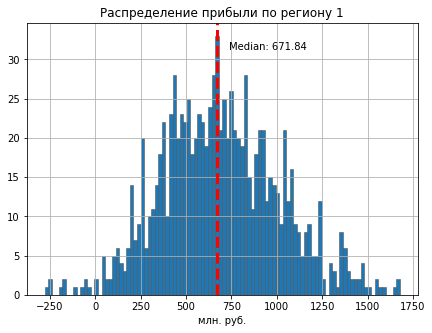

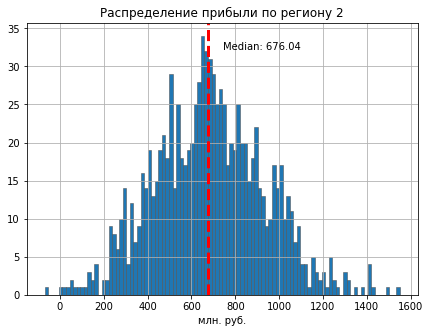

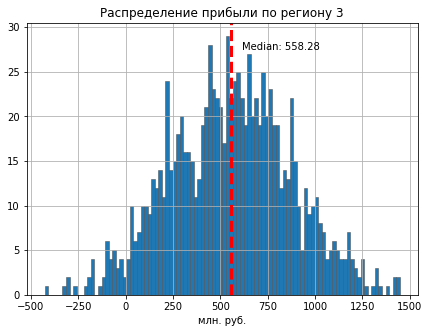

In [29]:
#посмотрим на распределение прибыли по регионам 
values = [values_0, values_1, values_2]
counter = 0
for i in values:
    counter +=1
    f, ax = plt.subplots(figsize=(7, 5))
    plt.title('Распределение прибыли по региону {}'.format(counter))
    (i/1000000).hist(
        #alette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
        bins = 100
    )
    plt.axvline((i/1000000).median(), color='r', linestyle='dashed', linewidth=3)
    min_ylim, max_ylim = plt.ylim()
    plt.text((i/1000000).median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format((i/1000000).median()))
    ax.set_xlabel('млн. руб.')
    
    #ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

На графиках распределения прибыли видно, что в первом регионе присутствует наибольшее смещение вправо относительно медианного значения, за счет чего и возникает преимущество в значениях потенциальной прибыли перед другими регионами. Однако наибольшее медианное значение потенциальной прибыли достигается во втором регионе.

In [30]:
mean_rev =[]
q_95 = []
risk=[]
for i in values:
    mean_rev.append(i.mean())
    q_95.append(st.t.interval(alpha=0.95, 
                                  df=len(i)-1, 
                                  loc=i.mean(),
                                  scale=i.sem()))
    risk.append((i[i<0].count()/len(i))*100)
outcome = pd.DataFrame(data = [] , columns= ['region', 'mean_revenue', '95_interval', 'risk'], index=[0,1,2])

In [31]:
outcome.region= [1,2,3]
outcome.mean_revenue = mean_rev
outcome['95_interval'] = q_95
outcome.risk = risk

In [32]:
outcome.mean_revenue = outcome.mean_revenue/1000000

In [33]:
outcome

,region,mean_revenue,95_interval,risk
0,1,688.075232,"(667916182.9954386, 708234280.0344319)",1.2
1,2,682.966829,"(667262855.6865036, 698670802.0573144)",0.1
2,3,554.429038,"(534627056.29032946, 574231018.7344503)",3.7


**Вывод**: Таким образом, среди регионов, где вероятность убытков меньше 3.7%, по средней потенциальной прибыли лидирует первый регион. Данный регион рекомендуется для разработки скважин.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован